In [1]:
# Import the required packages
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 256
LEARNING_RATE = 2e-4 
BETA_1 = 0.5
BETA_2 = 0.999
EPOCHS = 500
LATENT_DIMENSION = 100
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 1
NUM_EXAMPLES_TO_GENERATE = 25
IMG_DIMENSION = 784

### Dataset

We will use the famous Fashion-MNIST dataset for this purpose.

The Fashion-MNIST dataset consists of:
+ Database of 60,000 fashion images shown on the right.
+ Each image of size 28×28 ( grayscale ) is associated with a label from 10 categories like t-shirt, trouser, sneaker, etc.

The images are normalized, using the mean and standard deviation of 0.5. Note that there is one value for both as we are dealing with a grayscale image here. The normalization maps pixel values from [0, 255] to [-1, 1]. The range [-1, 1] is preferred, having proven useful for training GANs. 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
x_train = (x_train - 127.5) / 127.5 

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28, 1)

In [5]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIMENSION])
seed

<tf.Tensor: shape=(25, 100), dtype=float32, numpy=
array([[ 1.6145681 ,  2.159317  ,  0.382746  , ..., -1.3452717 ,
         1.6454488 , -0.5382172 ],
       [ 0.46382987, -0.6011623 ,  1.6834977 , ...,  0.7811916 ,
        -0.39126545,  0.34405053],
       [-0.7755715 ,  0.10278528,  0.7331659 , ..., -1.6995662 ,
         1.4900794 ,  0.2810321 ],
       ...,
       [ 0.8898312 ,  0.8335726 , -0.10427468, ...,  0.4443857 ,
         0.8455727 ,  0.2709745 ],
       [ 1.8400401 , -1.3749632 , -0.13825922, ..., -0.64712083,
         2.0789573 , -0.32636952],
       [ 0.01633413,  1.576542  ,  0.085963  , ...,  0.35288215,
        -0.27488324, -2.2804568 ]], dtype=float32)>

### Generator Network

The Generator is a fully connected network that takes a noise vector ( latent_dim ) as an input and outputs a 784-dimensional vector. Consider the generator as a decoder fed with a low-dimensional vector ( 100-d ) and outputs an upsampled high-dimensional vector ( 784-d ).

The network mainly consists of dense layers, leakyrelu & tanh activation function and batchnorm1d layers.

+ The first layer has 128 neurons, doubled at every new linear layer, upto 1024 neurons.

+ Leaky ReLU has been used as the activation function in this network for the intermediate layers with a negative slope as 0.2, meaning the features with a value below -0.2 will be squashed to 0.

+ BatchNorm1d is also used to normalize the intermediate feature vectors with an eps of 0.8 for numerical stability. Default: 1e-5.

+ The tanh activation at the output layer ensures that the pixel values are mapped in line with its own output, i.e., between (-1, 1) (remember, we normalized the images to range [-1, 1]).

In [6]:
def generator(IMG_DIMENSION):    
    inputs = keras.Input(shape=(100,), name='input_layer')
    x = layers.Dense(128, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(inputs)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_3')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
    x = layers.Dense(1024, kernel_initializer=tf.keras.initializers.he_uniform,  name='dense_4')(x) 
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_3')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    x = layers.Dense(IMG_DIMENSION, kernel_initializer=tf.keras.initializers.he_uniform, activation='tanh',  name='dense_5')(x) 
    outputs = tf.reshape(x, [-1, 28, 28, 1], name='Reshape_Layer')
    model = tf.keras.Model(inputs, outputs, name="Generator")
    return model

In [7]:
generator = generator(IMG_DIMENSION)

In [8]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 256)               1024      
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               13

### Discriminator Network

The discriminator is a binary classifier consisting of only fully-connected layers. It is a simpler model, with less layers than the generator.

the sequential-discriminator model is as follows:

+ Inputs the flattened image of dimension 784, and outputs a score between 0 and 1. 
+ Has Leaky Relu in the intermediate layers 
+ Has the Sigmoid activation function in the output layer
+ The forward function of the discriminator flattens the input feeds from the vector to the discriminator, and returns the result, indicating whether the image is real or fake.

In [9]:
def discriminator():
    inputs = keras.Input(shape=(28,28,1), name='input_layer')
    input = tf.reshape(inputs, [-1, 784], name='reshape_layer')
    x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(input)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    outputs = layers.Dense(1, kernel_initializer=tf.keras.initializers.he_uniform, activation='sigmoid', name='dense_3')(x) 
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

In [10]:
discriminator = discriminator()

In [11]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)               

### Loss

To model the objective of the generator and the discriminator, we will use the Binary Cross-Entropy loss function.

$L(\hat{y},y) = -\frac{1}{N}\sum_{i=1}^{N}[-y_{i} log(\hat{y_{i}}) - (1 - y_{i}) log(1 - \hat{y_{i}})]$

In [12]:
adversarial_loss = tf.keras.losses.BinaryCrossentropy()

### Generator Loss

Maximizing the probability D(G(z)) i.e. bringing it closer to 1.
For this objective, i.e., to maximize the probability D(G(z)) by the discriminator, the true label y is 1, and the predicted output $\hat{y}$ is D(G(z)). Putting these values in the BCE loss function, we get:

 \begin{equation*}G_{loss} = - log D(G(z))\end{equation*}

The generator_loss function is fed the fake outputs produced by the discriminator, as the input to the discriminator was fake images (produced by the generator). 

Note: The generator_loss is calculated with labels as real_target ( 1 ) because you want the generator to fool the discriminator and produce real images.

In [13]:
def generator_loss(fake_output):
    gen_loss = adversarial_loss(tf.ones_like(fake_output), fake_output)
    return gen_loss

### Discriminator Loss

For the first objective of the discriminator, i.e. to maximizing the probability $D(X_{real})$: the true label y is 1, and the predicted output $\hat{y}$ is $D(X_{real})$. Putting these values in the BCE loss function equation 1, we get:

\begin{equation*}D_{loss_{real}} = - log D(X_{real})\end{equation*}
    
For the second objective, i.e., to minimize the probability $D(X_{fake})$: the true label y is 0, and the predicted output $\hat{y}$ is $D(X_{fake})$, where $X_{fake}$ is equal to $G(z)$. Putting these values in the BCE loss function, we get:

 \begin{equation*}D_{loss_{fake}} = - log (1 - D(G(z))\end{equation*}
      

Therefore, the cumulative Discriminator loss becomes:

\begin{equation*}D_{loss} = D_{loss_{real}} + D_{loss_{fake}}\end{equation*}
\begin{equation*}D_{loss} = - log D(X_{real}) - log (1 - D(G(z))\end{equation*}

The discriminator loss is the sum of real and fake loss for its job is to differentiate between real images and those generated by the generator. Unlike the generator loss, here: 

+ The real (original images) output predictions label is 1
+ Fake output predictions label is 0

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = adversarial_loss(tf.ones_like(real_output), real_output)
    fake_loss = adversarial_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimization

The generator and discriminator are both optimized with the Adam optimizer. 

Three arguments are passed to the optimizer:
+ Generator and discriminator parameters, or weights to be optimized
+ A learning rate of 2e-2
+ Betas coefficients b1 & b2 for computing running averages of gradient during backpropagation

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = BETA_1, beta_2 = BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = BETA_1, beta_2 = BETA_2)

### Training

In the training loop

+ First, we sample the noise from a normal distribution and input it to the generator. 
+ The generator model then produces an image. 
+ We start by feeding the discriminator model real images. Then also input images produced by the generator model, which are classified as either real images (drawn from the training set) or fakes (produced by the generator). 
+ The loss is calculated for each of these models: gen_loss and disc_loss. 
After computing the gradients, the generator and discriminator parameters are updated, using the Adam optimizer.

Taking the train_dataset and Epochs as the parameters, the above train function calls the train_step function, at every new batch.

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled" into callable Tensorflow Graph .

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIMENSION])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Computing the gradients of generator and discriminator
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Updating generator and discriminator parameter
    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc,discriminator.trainable_variables))                              

In [17]:
# make a directory to store generated images
!mkdir generated_images_folder

In [18]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print (f'Time for epoch {epoch+1} is {time.time() - start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    #print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_images_folder/image_at_epoch_{epoch}.png')
    plt.show()

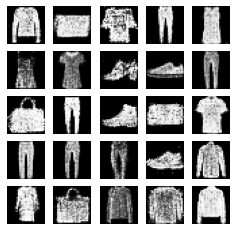

In [21]:
train(train_dataset, EPOCHS)